In [18]:
import ultralytics
ultralytics.checks()


Ultralytics YOLOv8.2.32  Python-3.12.4 torch-2.3.1+cpu CPU (AMD Ryzen 5 5600G with Radeon Graphics)
Setup complete  (12 CPUs, 31.3 GB RAM, 125.5/930.9 GB disk)


In [39]:
import xml.etree.ElementTree as ET
import glob
import os
import json
from tqdm import tqdm

road_sign_root = 'C:/project/object_detection_road/dataset/road_sign_detection/'
annot_path = os.path.join(road_sign_root,"annotations")
img_path = os.path.join(road_sign_root, "images")
label_path = os.path.join(road_sign_root, "labels")

if not os.path.exists(label_path):
    os.makedirs(label_path)

In [41]:
# Define the classes list

import os
import glob
import xml.etree.ElementTree as ET
from tqdm import tqdm
# *.xml -> *.txt
classes = []

# Specify the annotation path
annot_path = './dataset/xml_files'
label_path = './dataset/yolo_labels'

# 라벨 경로가 없으면 생성
if not os.path.exists(label_path):
    os.makedirs(label_path)
    print(f"Created label path: {label_path}")

# Load the list of XML files
files = glob.glob(os.path.join(annot_path, '*.xml'))

for fil in tqdm(files):
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]

    result = []

    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall('object'):
        label = obj.find("name").text
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        with open(os.path.join(label_path, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

0it [00:00, ?it/s]


In [42]:
cd c:/project/object_detection_road/dataset

c:\project\object_detection_road\dataset


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [27]:
import random
from shutil import copyfile, rmtree

road_sign_path = './road_sign_detection'
label_ext = '.txt'
img_ext = '.png'

# 저장 경로 만들기
folder_list = [
    'road_sign_detection/train', 
    'road_sign_detection/val', 
    'road_sign_detection/test',
    'road_sign_detection', 
    'road_sign_detection/train/labels',
    'road_sign_detection/train/images',
    'road_sign_detection/val/images', 
    'road_sign_detection/val/labels'
]

for folder in folder_list:
    abs_folder = os.path.join(road_sign_path, folder)
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")


In [43]:
# Todo 데이터셋 Train/Test 분리

# 1. file  목록 작성
file_list = os.listdir(os.path.join(road_sign_path, "images"))

# 2. shuffle
random.shuffle(file_list)

# 3. Train/Test 분리
test_ratio = 0.1
test_list = file_list[:int(len(file_list)*test_ratio)]
train_list = file_list[int(len(file_list)*test_ratio):]

print(f"train : {len(train_list)}, test : {len(test_list)}")

# 4. 파일 이동
for i in test_list:
    f_name = os.path.splitext(i)[0]
    copyfile(os.path.join(road_sign_path, 'images', f_name + img_ext), os.path.join(road_sign_path, 'val/images', f_name + img_ext))
    copyfile(os.path.join(road_sign_path, 'labels', f_name + label_ext), os.path.join(road_sign_path, 'val/labels', f_name + label_ext))

for i in train_list:
    f_name = os.path.splitext(i)[0]
    copyfile(os.path.join(road_sign_path, 'images', f_name + img_ext), os.path.join(road_sign_path, 'train/images', f_name + img_ext))
    copyfile(os.path.join(road_sign_path, 'labels', f_name + label_ext), os.path.join(road_sign_path, 'train/labels', f_name + label_ext))

train : 790, test : 87


In [44]:
#config파일 만들기

import yaml
import os
from ultralytics import YOLO

# 데이터 설정
data = dict()
data['train'] = 'C:/project/object_detection_road/dataset/road_sign_detection/train'
data['val'] = 'C:/project/object_detection_road/dataset/road_sign_detection/val'
data['test'] = 'C:/project/object_detection_road/dataset/road_sign_detection/test'

data['nc'] = 4
data['name'] = ['Traffic_light', 'Speedlimit', 'Crosswalk', 'Stop']


config_path = 'C:/project/object_detection_road/project_road_sign_detection/road_sign.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(data, f, default_flow_style=False)


# training

In [45]:
cd C:/project/object_detection_road/project_road_sign_detection/

C:\project\object_detection_road\project_road_sign_detection


In [47]:
from ultralytics import YOLO
model = YOLO('yolov8s.yaml')
result = model.train(data ='road_sign_yaml', epochs = 50, batch = 32, device = 'cpu', patience = 30, name='road_sign_s')
# 'data' 인자에 실제 config 파일 경로를 지정합니다.

New https://pypi.org/project/ultralytics/8.2.35 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.32  Python-3.12.4 torch-2.3.1+cpu 


ValueError: Invalid CUDA 'device=1' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: -1
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [48]:
# todo validation
# 1. import library
from ultralytics import YOLO

# 2. road model
model = YOLO('best_road_sign.pt')

# 3. Validate the model
metrics = model.val()

# 4. validation 결과 print
print("map50-95", metrics.box.map)
print("map50", metrics.box.map50)

Ultralytics YOLOv8.2.32  Python-3.12.4 torch-2.3.1+cpu CPU (AMD Ryzen 5 5600G with Radeon Graphics)
YOLOv8s summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning C:\project\object_detection_road\dataset\road_sign_detection\val\labels... 366 images, 0 backgrounds, 366 corrupt: 100%|██████████| 366/366 [00:00<00:00, 808.62it/s]

val: WARNING  C:\project\object_detection_road\dataset\road_sign_detection\val\images\road0.png: ignoring corrupt image/label: could not convert string to float: '0.57303370786516850.36750.411985018726591770.425'
val: WARNING  C:\project\object_detection_road\dataset\road_sign_detection\val\images\road100.png: ignoring corrupt image/label: could not convert string to float: '0.49750.429870129870129850.820.8337662337662337'
val: WARNING  C:\project\object_detection_road\dataset\road_sign_detection\val\images\road103.png: ignoring corrupt image/label: could not convert string to float: '0.48250.493355481727574760.520.8205980066445183'
val: WARNING  C:\project\object_detection_road\dataset\road_sign_detection\val\images\road105.png: ignoring corrupt image/label: could not convert string to float: '0.51333333333333330.653750.84666666666666670.5775'
val: WARNING  C:\project\object_detection_road\dataset\road_sign_detection\val\images\road107.png: ignoring corrupt image/label: could not conv

ValueError: not enough values to unpack (expected 3, got 0)

#inference

In [2]:
cd c:/project/object_detection_road/project_road_sign_detection

c:\project\object_detection_road\project_road_sign_detection


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]



0: 640x448 1 Trafic_light, 356.1ms
Speed: 4.0ms preprocess, 356.1ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 448)


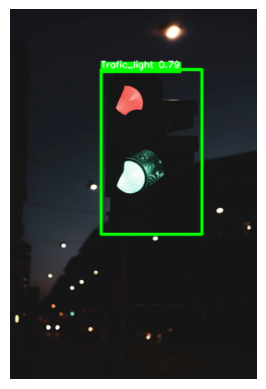


0: 480x640 1 Speedlimit, 312.1ms
Speed: 2.0ms preprocess, 312.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


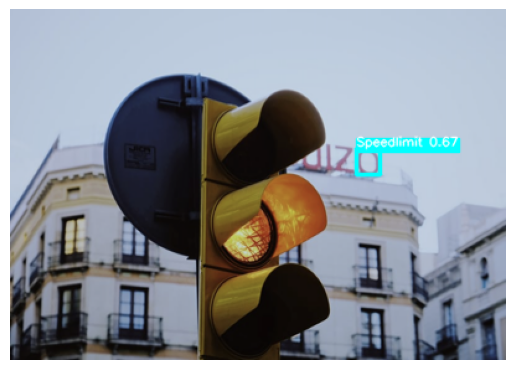


0: 448x640 1 Trafic_light, 293.1ms
Speed: 2.0ms preprocess, 293.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


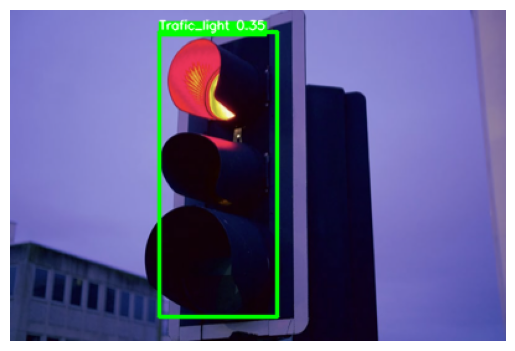


0: 640x640 2 Speedlimits, 1 Stop, 437.1ms
Speed: 3.0ms preprocess, 437.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


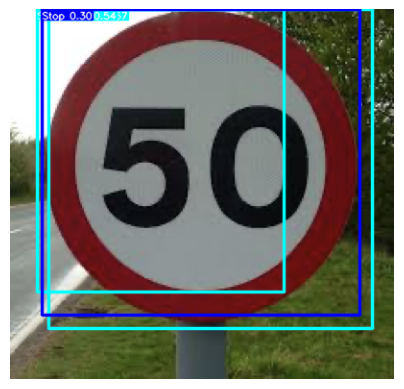


0: 320x640 1 Speedlimit, 213.0ms
Speed: 1.0ms preprocess, 213.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


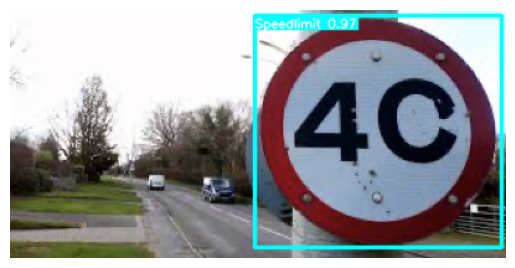


0: 448x640 1 Speedlimit, 292.1ms
Speed: 2.0ms preprocess, 292.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


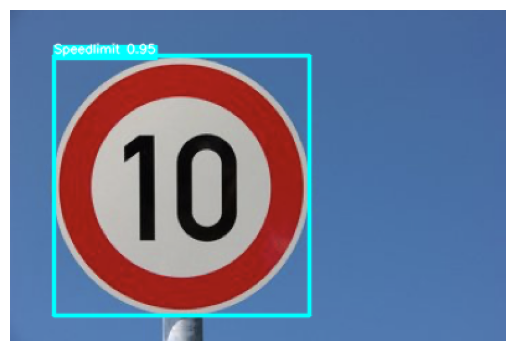


0: 512x640 1 Speedlimit, 343.1ms
Speed: 2.0ms preprocess, 343.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


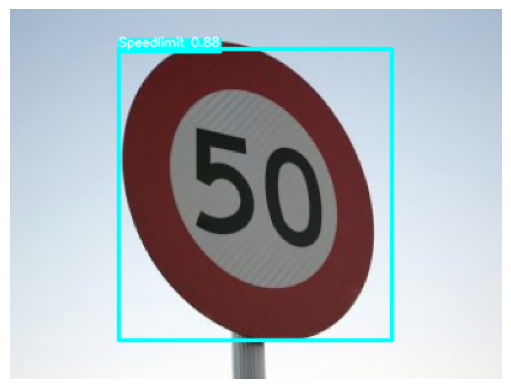


0: 608x640 2 Speedlimits, 1 Stop, 416.1ms
Speed: 2.0ms preprocess, 416.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


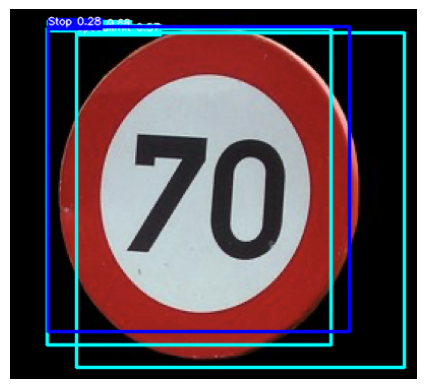


0: 640x480 1 Speedlimit, 322.1ms
Speed: 1.0ms preprocess, 322.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


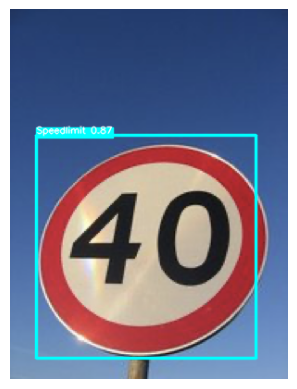


0: 640x448 1 Speedlimit, 299.1ms
Speed: 2.0ms preprocess, 299.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


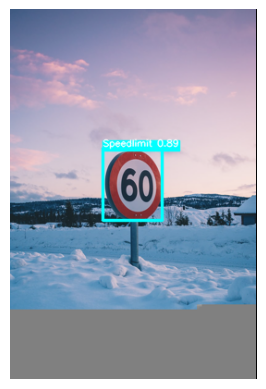


0: 640x512 1 Speedlimit, 346.1ms
Speed: 1.0ms preprocess, 346.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


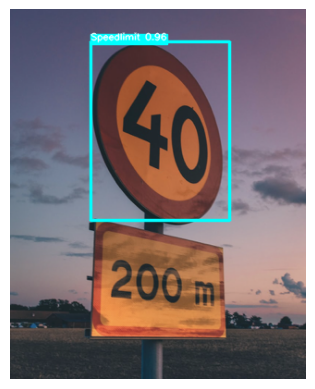


0: 416x640 1 Speedlimit, 277.1ms
Speed: 1.0ms preprocess, 277.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


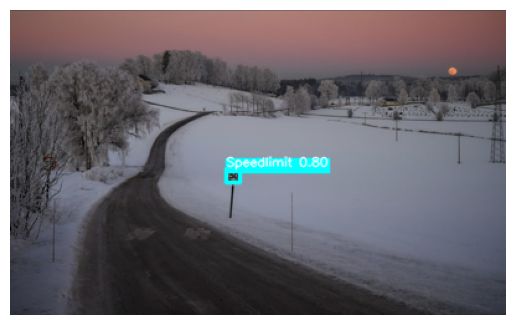


0: 448x640 1 Speedlimit, 301.1ms
Speed: 2.0ms preprocess, 301.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


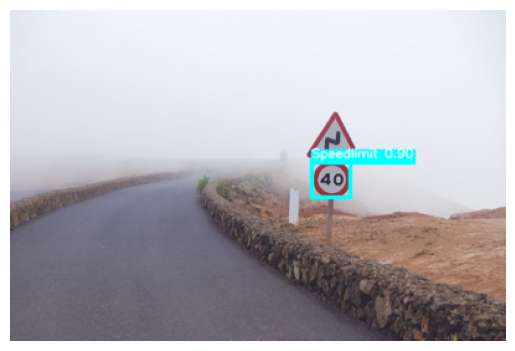


0: 480x640 3 Trafic_lights, 312.1ms
Speed: 2.0ms preprocess, 312.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


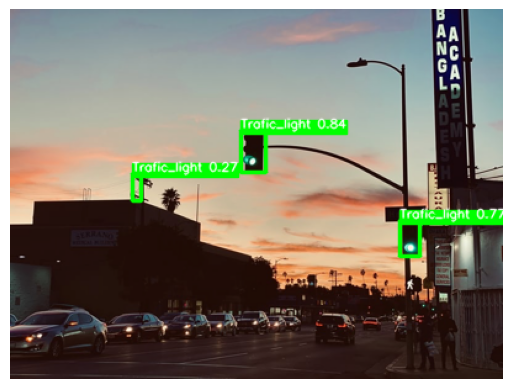


0: 448x640 1 Speedlimit, 286.1ms
Speed: 2.0ms preprocess, 286.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


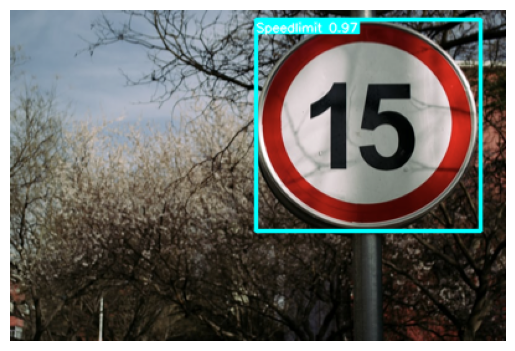


0: 448x640 1 Speedlimit, 288.1ms
Speed: 1.0ms preprocess, 288.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


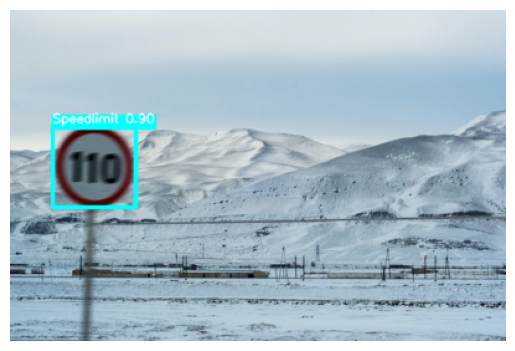


0: 448x640 1 Speedlimit, 303.1ms
Speed: 2.0ms preprocess, 303.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


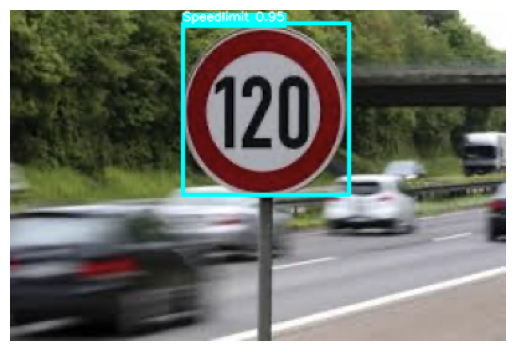


0: 448x640 1 Speedlimit, 285.1ms
Speed: 1.0ms preprocess, 285.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


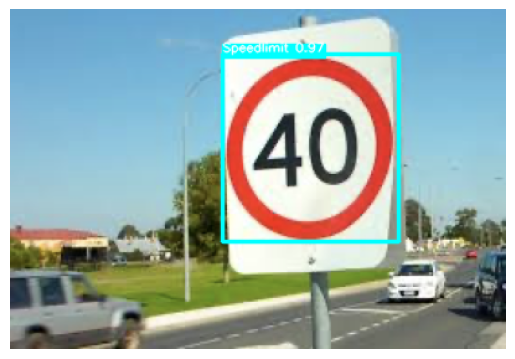


0: 416x640 1 Speedlimit, 288.1ms
Speed: 1.0ms preprocess, 288.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


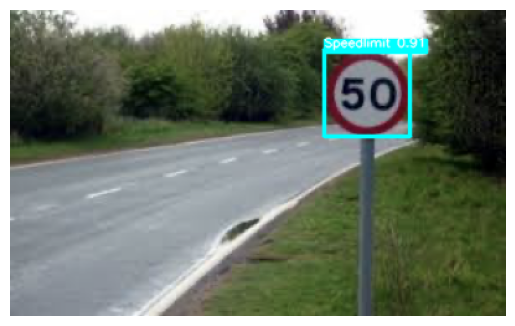

KeyboardInterrupt: 

In [3]:
from ultralytics import YOLO
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

class Annotator:
    def __init__(self, image, line_width=None, font_size=None):
        self.image = image
        self.lw = line_width or max(round(sum(image.shape) / 2 * 0.003), 2)
        self.fs = font_size or max(self.lw - 1, 1)
        self.colors = [(0, 255, 0), (255, 255, 0), (0, 0, 255), (255, 0, 0)]

    def box_label(self, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(self.image, (x1, y1), (x2, y2), color, thickness=self.lw, lineType=cv2.LINE_AA)
        if label:
            tf = max(self.lw - 1, 1)  # font thickness
            w, h = cv2.getTextSize(label, 0, fontScale=self.fs / 3, thickness=tf)[0]  # text width, height
            outside = y1 - h >= 3
            cv2.rectangle(self.image,
                          (x1, y1 - h if outside else y1),
                          (x1 + w, y1 + 3 if outside else y1 + h + 3),
                          color, -1, cv2.LINE_AA)  # filled
            cv2.putText(self.image,
                        label,
                        (x1, y1 - 2 if outside else y1 + h + 2),
                        0,
                        self.fs / 3,
                        txt_color,
                        thickness=tf,
                        lineType=cv2.LINE_AA)

    def result(self):
        return self.image

# 모델 로드
model = YOLO('best_road_sign.pt')

# 테스트 이미지 및 결과 디렉토리 설정
root_folder = 'C:/project/object_detection_road/dataset/road_sign_detection/images'
result_folder = 'C:/project/object_detection_road/project_road_sign_detection/result'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

test_img_list = os.listdir(root_folder)

device = 'cpu'
color_dict = [(0, 255, 0), (255, 255, 0), (0, 0, 255), (255, 0, 0)]
color_dict2 = [(0, 0, 0), (0, 0, 0), (255, 255, 255), (255, 255, 255)]

# 이미지에 대해 추론 수행
for img_name in test_img_list:
    img_path = os.path.join(root_folder, img_name)
    img = cv2.imread(img_path)

    results = model.predict(source=img, device=device, save=False)

    for result in results:
        annotator = Annotator(img)
        for box in result.boxes:
            cls = int(box.cls[0])
            conf = box.conf[0]
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            label = f'{model.names[cls]} {conf:.2f}'
            annotator.box_label([x1, y1, x2, y2], label, color=color_dict[cls])

        annotated_img = annotator.result()

        # 결과 저장
        result_img_path = os.path.join(result_folder, img_name)
        cv2.imwrite(result_img_path, annotated_img)

        # 결과 출력
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
